In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("exoplanets_clean_full.csv")   # change name if needed

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34993 entries, 0 to 34992
Data columns (total 62 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pl_name              34993 non-null  object 
 1   hostname             34993 non-null  object 
 2   pl_rade              34993 non-null  float64
 3   pl_bmasse            34993 non-null  float64
 4   pl_eqt               34993 non-null  float64
 5   pl_orbper            34993 non-null  float64
 6   pl_orbsmax           34993 non-null  float64
 7   st_spectype          34993 non-null  object 
 8   st_teff              34993 non-null  float64
 9   st_rad               34993 non-null  float64
 10  st_met               34993 non-null  float64
 11  sy_dist              34993 non-null  float64
 12  st_lum               34993 non-null  float64
 13  pl_density           34993 non-null  float64
 14  pl_rade_missing      34993 non-null  bool   
 15  pl_bmasse_missing    34993 non-null 

In [2]:
df.isnull().sum().sort_values(ascending=False)


pl_name              0
hostname             0
pl_rade              0
pl_bmasse            0
pl_eqt               0
                    ..
sy_dist_zs           0
log_pl_rade_zs       0
log_pl_bmasse_zs     0
log_st_lum_zs        0
log_pl_orbsmax_zs    0
Length: 62, dtype: int64

In [5]:
num_cols = [
    "pl_rade","pl_bmasse","pl_density","pl_eqt",
    "pl_orbper","pl_orbsmax","st_teff","st_lum","st_met"
]

# Keep only existing columns
num_cols = [c for c in num_cols if c in df.columns]

for c in num_cols:
    df[c] = df[c].fillna(df[c].median())
if "st_spectype" in df.columns:
    df["st_spectype"] = df["st_spectype"].fillna("Unknown")


In [7]:
def remove_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    return data[(data[col] >= Q1 - 1.5*IQR) &
                (data[col] <= Q3 + 1.5*IQR)]

for col in ["pl_rade","pl_bmasse","pl_eqt"]:
    if col in df.columns:
        df = remove_outliers_iqr(df, col)
df = df[
    (df["pl_rade"] > 0) &
    (df["pl_bmasse"] > 0) &
    (df["pl_orbper"] > 0)
]



In [ ]:
def simplify_star_type(s):
    if not isinstance(s, str):
        return "Unknown"
    s = s.strip().upper()
    return s[0] if s[0] in "OBAFGKM" else "Other"

df["st_type_simple"] = df["st_spectype"].apply(simplify_star_type)
df = pd.get_dummies(df, columns=["st_type_simple"], prefix="stype", drop_first=True)#One-Hot Encoding


In [11]:
# Feature Engineering
#  Habitability Score Index (HSI)

# A simple scientific proxy using:

# Planet radius

# Temperature

# Stellar flux (or distance)

df["HSI"] = (
    (1 / (1 + abs(df["pl_rade"] - 1))) *
    (1 / (1 + abs(df["pl_eqt"] - 288))) *
    (1 / (1 + df["pl_orbsmax"]))
)
#Stellar Compatibility Index (SCI)
df["SCI"] = (
    (1 / (1 + abs(df["st_teff"] - 5778))) *
    (1 / (1 + abs(df["st_lum"] - 1))) *
    (1 / (1 + abs(df["st_met"])))
)


In [12]:
from sklearn.preprocessing import StandardScaler

scale_cols = [
    "pl_rade","pl_bmasse","pl_density","pl_eqt",
    "pl_orbper","pl_orbsmax","st_teff","st_lum",
    "st_met","HSI","SCI"
]

scale_cols = [c for c in scale_cols if c in df.columns]

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled, columns=[c+"_scaled" for c in scale_cols])
df = pd.concat([df, df_scaled], axis=1)


In [13]:
df[scale_cols].describe()


,pl_rade,pl_bmasse,pl_density,pl_eqt,pl_orbper,pl_orbsmax,st_teff,st_lum,st_met,HSI,SCI
count,8765.000000,8.765000e+03,8.765000e+03,8765.0,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000
mean,2.275373,2.320147e+02,2.270378e-01,795.0,94.985585,0.187768,5453.233897,1.298698,-0.004559,0.000785,0.005651
std,0.037501,5.684666e-14,2.775716e-17,0.0,2859.708224,3.045437,761.208592,1.510603,0.133992,0.000038,0.022503
min,2.047000,2.320147e+02,2.270378e-01,795.0,0.219700,0.020000,3000.000000,0.002752,-0.920000,0.000004,0.000004
25%,2.280000,2.320147e+02,2.270378e-01,795.0,4.887534,0.100300,5146.000000,0.421407,-0.020000,0.000785,0.000685
50%,2.280000,2.320147e+02,2.270378e-01,795.0,10.506826,0.100300,5605.140000,0.863873,-0.020000,0.000785,0.001702
75%,2.280000,2.320147e+02,2.270378e-01,795.0,23.589202,0.100300,5835.360000,1.663321,0.020000,0.000785,0.005230
max,2.420000,2.320147e+02,2.270378e-01,795.0,171667.500000,214.000000,27500.000000,53.456149,0.480000,0.000899,0.738316


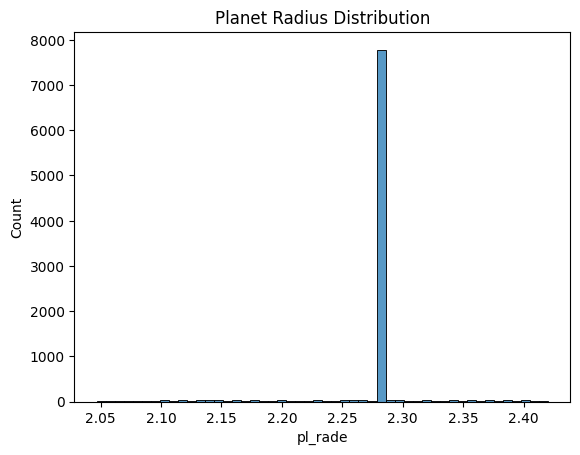

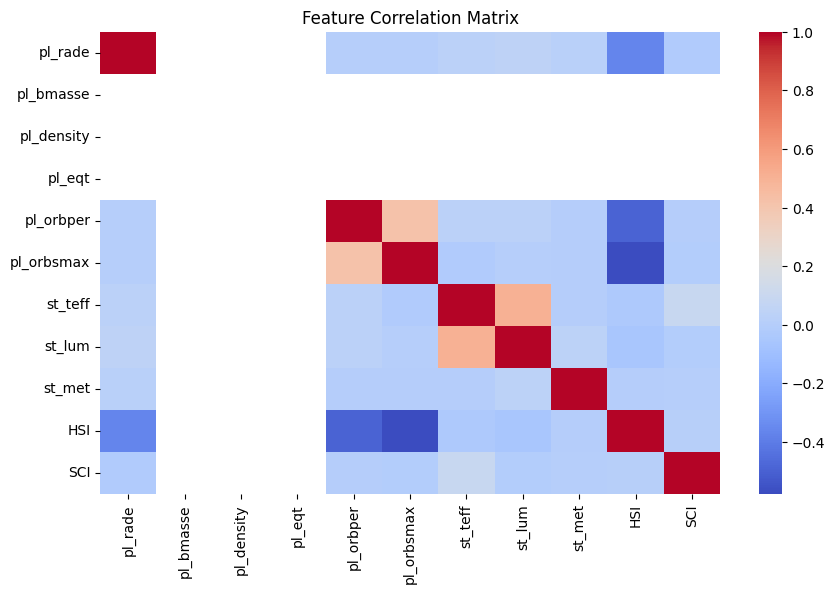

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution
sns.histplot(df["pl_rade"], bins=50)
plt.title("Planet Radius Distribution")
plt.show()

# Correlation
plt.figure(figsize=(10,6))
sns.heatmap(df[scale_cols].corr(), cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


In [15]:
df.to_csv("exoplanets_features.csv", index=False)
print("Preprocessing completed successfully!")


Preprocessing completed successfully!
